In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
class Conv2D:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.input_data = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, input_data):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = input_data.shape
        out_h = (H + 2*self.pad - FH) // self.stride + 1
        out_w = (W + 2*self.pad - FW) // self.stride + 1

        col = im2col(input_data, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.input_data = input_data
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.input_data.shape, FH, FW, self.stride, self.pad)
        return dx


In [3]:
class Pooling2D:
    def __init__(self, kernel_size=2, stride=2, pad=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad

        self.input_data = None
        self.arg_max = None

    def forward(self, input_data):
        N, C, H, W = input_data.shape
        out_h = (H - self.kernel_size) // self.stride + 1
        out_w = (W - self.kernel_size) // self.stride + 1

        col = im2col(input_data, self.kernel_size, self.kernel_size, self.stride, self.pad)
        col = col.reshape(-1, self.kernel_size*self.kernel_size)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        output = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.input_data = input_data
        self.arg_max = arg_max

        return output

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.kernel_size * self.kernel_size
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.input_data.shape, self.kernel_size, self.kernel_size, self.stride, self.pad)

        return dx


In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
      t = t.reshape(1, t.size)
      y = y.reshape(1, y.size)

    if t.size == y.size:
      t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(x, y):
    pred_y = softmax(x)
    return cross_entropy_error(pred_y, y)


In [5]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

class Layer:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.input_data = None
        self.input_data_shape = None

        self.dW = None
        self.db = None

    def forward(self, input_data):
        self.input_data_shape = input_data.shape
        input_data = input_data.reshape(input_data.shape[0], -1)
        self.input_data = input_data

        out = np.dot(self.input_data, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.input_data.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.input_data_shape)

        return dx

class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

In [6]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


In [7]:
class MyModel:
    def __init__(self, input_dim=(1, 28, 28), num_outputs=10):
        conv1_block = {'num_filters':30,
                      'kernel_size':3,
                      'stride':1,
                      'pad':0}
        conv2_block = {'num_filters':60,
                      'kernel_size':3,
                      'stride':1,
                      'pad':0}

        input_size = input_dim[1]
        conv1_output_size = ((input_size - conv1_block['kernel_size'] + 2*conv1_block['pad']) // conv1_block['stride']) + 1
        pool1_output_size = int(conv1_block['num_filters'] * (conv1_output_size/2) * (conv1_output_size/2))

        conv2_output_size = ((conv1_output_size // 2 - conv2_block['kernel_size'] + 2*conv2_block['pad']) // conv2_block['stride']) + 1
        pool2_output_size = conv2_block['num_filters'] * (conv2_output_size // 2) * (conv2_output_size // 2)

        self.params = {}
        self.params['W1'], self.params['b1'] = self.__init_weight_conv(conv1_block['num_filters'], input_dim[0], 3)
        self.params['W2'], self.params['b2'] = self.__init_weight_conv(conv2_block['num_filters'], conv1_block['num_filters'], 3)
        self.params['W3'], self.params['b3'] = self.__init_weight_fc(pool2_output_size, 256)
        self.params['W4'], self.params['b4'] = self.__init_weight_fc(256, num_outputs)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv2D(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = Pooling2D(kernel_size=2, stride=2)
        self.layers['Conv2'] = Conv2D(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool2'] = Pooling2D(kernel_size=2, stride=2)
        self.layers['Affine1'] = Layer(self.params['W3'], self.params['b3'])
        self.layers['ReLU3'] = ReLU()
        self.layers['Affine2'] = Layer(self.params['W4'], self.params['b4'])
        self.last_layer = Softmax()

    def __init_weight_conv(self, num_filters, data_dim, kernel_size, stride=1, pad=0, weight_std=0.01):
        W = weight_std * np.random.randn(num_filters, data_dim, kernel_size, kernel_size)
        b = np.zeros(num_filters)

        return W, b

    def __init_weight_fc(self, input_size, output_size, weight_std=0.01):
        W = weight_std * np.random.randn(input_size, output_size)
        b = np.zeros(output_size)

        return W, b

    def forward(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, y):
        y_pred = self.forward(x)
        return self.last_layer.forward(y_pred, y)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y_pred = self.forward(tx)
            y_pred = np.argmax(y_pred, axis=1)
            acc += np.sum(y_pred == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W4'], grads['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [14]:
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10
x_train, x_test = np.expand_dims(x_train, axis=1), np.expand_dims(x_test, axis=1)

x_train = x_train[:3000]
x_test = x_test[:500]
y_train = y_train[:3000]
y_test = y_test[:500]


epochs = 10
train_size = x_train.shape[0]
batch_size = 200
lr = 0.005
current_iter = 0
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

model = MyModel()
optimizer = SGD(lr)

In [15]:
for epoch in range(epochs):
    for i in range(iter_per_epoch):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        y_batch = y_train[batch_mask]

        grads = model.gradient(x_batch, y_batch)
        optimizer.update(model.params, grads)

        loss = model.loss(x_batch, y_batch)
        train_loss_list.append(loss)

        x_train_sample, y_train_sample = x_train, y_train
        x_test_sample, y_test_sample = x_test, y_test

        train_acc = model.accuracy(x_train_sample, y_train_sample)
        test_acc = model.accuracy(x_test_sample, y_test_sample)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        current_iter += 1

    print('Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch, loss, train_acc, test_acc))


Epoch: 0, Train Loss: 2.2954, Train Accuracy: 0.3067, Test Accuracy: 0.3140
Epoch: 1, Train Loss: 2.2791, Train Accuracy: 0.4537, Test Accuracy: 0.4200
Epoch: 2, Train Loss: 2.2185, Train Accuracy: 0.5360, Test Accuracy: 0.4740
Epoch: 3, Train Loss: 1.9346, Train Accuracy: 0.6493, Test Accuracy: 0.5680
Epoch: 4, Train Loss: 1.1481, Train Accuracy: 0.6170, Test Accuracy: 0.6160
Epoch: 5, Train Loss: 0.6203, Train Accuracy: 0.6910, Test Accuracy: 0.6540
Epoch: 6, Train Loss: 0.7690, Train Accuracy: 0.7020, Test Accuracy: 0.6780
Epoch: 7, Train Loss: 0.3950, Train Accuracy: 0.8613, Test Accuracy: 0.8200
Epoch: 8, Train Loss: 0.3191, Train Accuracy: 0.8757, Test Accuracy: 0.8400
Epoch: 9, Train Loss: 0.2800, Train Accuracy: 0.8930, Test Accuracy: 0.8700


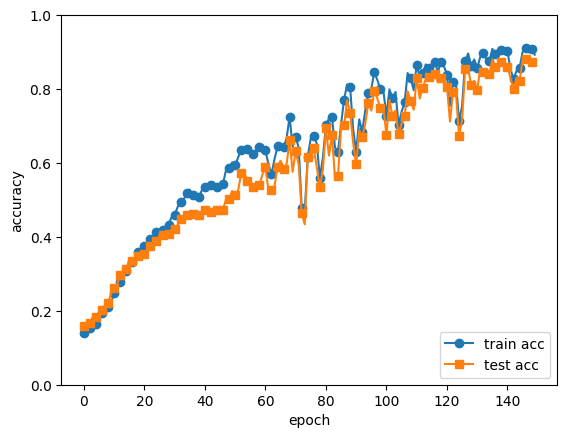

In [16]:
x = np.arange(current_iter)
plt.plot(x, train_acc_list, marker='o', label='train acc', markevery=2)
plt.plot(x, test_acc_list, marker='s', label='test acc', markevery=2)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

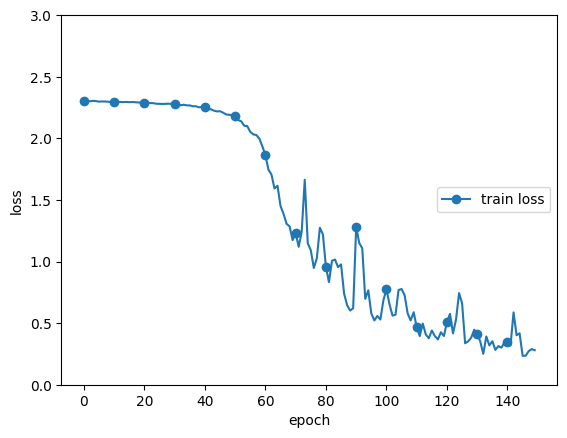

In [18]:
x = np.arange(current_iter)
plt.plot(x, train_loss_list, marker='o', label='train loss', markevery=10)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 3.0)
plt.legend(loc='right')
plt.show()